In [ ]:
import numpy as np
import pandas as pd
import os
import torch 
from torch import nn, optim 
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torch.utils.data
import matplotlib.pyplot as plt
import time
import itertools
import glob
import cv2

In [ ]:
!git clone https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer
%cd Ranger-Deep-Learning-Optimizer
!pip install -e . 

fatal: destination path 'Ranger-Deep-Learning-Optimizer' already exists and is not an empty directory.
/content/Ranger-Deep-Learning-Optimizer
Obtaining file:///content/Ranger-Deep-Learning-Optimizer
  Found existing installation: ranger 0.1.dev0
    Can't uninstall 'ranger'. No files were found to uninstall.
  Running setup.py develop for ranger


In [ ]:
from ranger import Ranger  
%cd ..

/content


In [ ]:
!pip install albumentations

     |████████████████████████████████| 634kB 17.3MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=593d17201e18b5ea16fb2a094bf110ca1d2ffceed99525ac3db5aa91d0a9e6b4
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [ ]:
#https://paperswithcode.com/paper/sharpness-aware-minimization-for-efficiently-1
!git clone https://github.com/davda54/sam.git
%cd sam
import sam
print("Imported SAM Successfully from github .py file")
%cd ..

fatal: destination path 'sam' already exists and is not an empty directory.
/content/sam
Imported SAM Successfully from github .py file
/content


In [ ]:
import albumentations as A
import imgaug.augmenters as iaa

In [ ]:
#Try the effecient net
!pip install timm
import timm

In [ ]:
!pip install git+https://github.com/ildoonet/cutmix

  Cloning https://github.com/ildoonet/cutmix to /tmp/pip-req-build-9z79jjzo
  Running command git clone -q https://github.com/ildoonet/cutmix /tmp/pip-req-build-9z79jjzo
  Created wheel for cutmix: filename=cutmix-0.1-cp36-none-any.whl size=3603 sha256=a6952358ade8386c45e082edf22b39fbea470e54d89935550881860b4a42087d
  Stored in directory: /tmp/pip-ephem-wheel-cache-67_8b0ez/wheels/8a/40/20/615302921d0fef73e55b17b5dd57169d4879dfe6dd7ad8ff50
Successfully built cutmix


In [ ]:
from cutmix.cutmix import CutMix

In [ ]:
!pip install git+https://github.com/ildoonet/pytorch-randaugment
from RandAugment import RandAugment

### New additions:

* Ranger Base Optimizer
* Sam optimizer
* New Albumentations
* Mish Activation
* How to build a resnet from pytorch
* Transformer
* Self-Attention in Computer Vision
* Label Smooth Cross Entropy Loss
* Cutmix augmentation on labels and images
* Cutmix Cross Entropy Loss


### More Additions
RandAugment https://github.com/ildoonet/pytorch-randaugment

Maxup Loss for Cutmix
https://github.com/elis2496/maxup_implementation
(Have to do some train function refacto



#### Pip Install and import other packages

In [ ]:
!pip install pytorch_lightning

In [ ]:
from pytorch_lightning.metrics import Accuracy, Metric, F1, Precision, Recall, ConfusionMatrix

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
#Uncomment to load data in
import tarfile
my_tar = tarfile.open('/content/drive/MyDrive/imagewoof2-160.tgz')
my_tar.extractall() # specify which folder to extract to
my_tar.close()

In [ ]:
def create_dataframe(image_file_paths):
    
    classes = ["n02086240", "n02087394", "n02088364", "n02089973", "n02093754", "n02096294", "n02099601", "n02105641", "n02111889", "n02115641"]
    dataframe = pd.DataFrame(image_file_paths, columns = ["image_path"])
    dataframe["label"] = dataframe.apply(lambda row: classes.index(row["image_path"].rsplit('/', 2)[-2]), axis = 1)
    
    return dataframe

#Use glob glob to find pattern in file types to get list of all image paths
image_file_paths_train = glob.glob("/content/imagewoof2-160/train/*/*.JPEG")
image_file_paths_test = glob.glob("/content/imagewoof2-160/val/*/*.JPEG")
image_woof_dataframe_train = create_dataframe(image_file_paths_train)
image_woof_dataframe_test = create_dataframe(image_file_paths_test)
print(np.unique(image_woof_dataframe_train.label))
print(np.unique(image_woof_dataframe_test.label))

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


In [ ]:
class ImageWoofDataset():
    def __init__(self, df, transform, extra_transforms = False):
        
        self.transform = transform
        self.df = df
        self.extra_transforms = extra_transforms
        
        
    def __getitem__(self, index):
        
        image_path = self.df["image_path"].iloc[index]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.df["label"].iloc[index]

        if self.extra_transforms:
          extra_trans = A.Compose([
                         A.ElasticTransform(),
                         A.RandomBrightnessContrast(),
                         A.IAAPerspective(),
                         ])
          image = extra_trans(image = image)["image"]

          

        if self.transform != None:
            image = self.transform(image)
            
        return (image, label)
    
    
    def __len__(self):
        
        return len(self.df)

In [ ]:
data_dir = "/content/imagewoof2-160"
batch_size = 64
#Set random seed
np.random.seed(42)
torch.manual_seed(42)

train_transform = transforms.Compose([
                                      transforms.ToPILImage(),
                                      transforms.Resize(128),
                                      transforms.RandomCrop(128),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(20),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_transform = transforms.Compose([
                                     transforms.ToPILImage(),
                                     transforms.Resize(140),
                                     transforms.CenterCrop(128),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


train_transform.transforms.insert(0, RandAugment(N = 1, M = 2))

train_data = ImageWoofDataset(image_woof_dataframe_train, transform = train_transform, extra_transforms= False)
train_data = CutMix(train_data, num_class = 10, beta = 0.1, num_mix = 2)
test_data = ImageWoofDataset(image_woof_dataframe_test, transform = test_transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

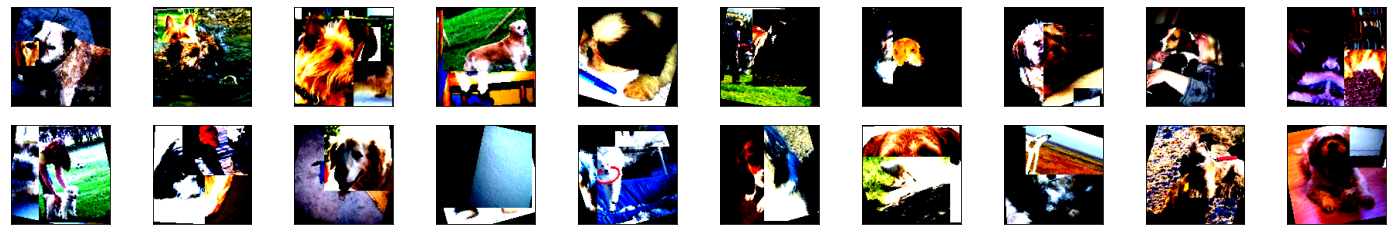

In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    

In [ ]:
def Graph_Maker(Train_l,Test_L, print_every):
  epoch_count = range(1, len(Train_l) + 1)
  plt.title("Loss vs. [Check Train Note]")
  plt.xlabel("Number of {} Training Batches".format(print_every))
  plt.ylabel("Loss")
  plt.plot(epoch_count,Train_l, 'r--')
  plt.plot(epoch_count,Test_L, 'b-')
  plt.legend(['Training Loss', 'Test Loss'])
  plt.xticks(np.arange(1, len(Train_l)+1))
  plt.show()

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
  
  accuracy = np.trace(cm) / float(np.sum(cm))
  misclass = 1 - accuracy

  if cmap is None:
    cmap = plt.get_cmap('Blues')

  plt.figure(figsize=(8, 6))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()

  if target_names is not None:
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


  thresh = cm.max() / 1.5 if normalize else cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      if normalize:
        plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
      else:
        plt.text(j, i, "{:,}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
  plt.show()

In [ ]:
def train(net, epochs, train_loader, test_loader, lr, criterion, print_every = 40, weight_decay = 0, zero_base_line = False, enable_scheduler = True):
    
    cancel = False
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #Create metrics
    test_accuracy = Accuracy(compute_on_step = False).to(device)
    train_accuracy = Accuracy(compute_on_step = False).to(device)
    test_prec = Precision(num_classes=10, compute_on_step = False).to(device)
    test_recall = Recall(num_classes=10, compute_on_step = False).to(device)
    test_f1 = F1(num_classes=10, compute_on_step = False).to(device) 
    confmat = ConfusionMatrix(num_classes=10).to(device)

    base_optimizer = Ranger
    optimizer = sam.SAM(net.parameters(), base_optimizer, lr = lr, weight_decay = weight_decay)

    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = len(train_loader))
    
    net.to(device)
    print("Device: {}".format(device))
    print("Optimizer: {}".format(optimizer))
    print("Note: Train Loss is calculated after {} batches of the train loader. While the test loss is calculated over the whole test_loader".format(print_every))
    print("For example: a sequence might be train for {} batches then test on everything and then train for the next {} batches then test on everything ... ".format(print_every, print_every))
    
    start_time = time.time()

    #For graphing
    train_list = []
    test_list = []
    
    for epoch in range(epochs):

        net.train()

        # if (epoch + 1)/(epochs) > 0.3:
        #   print("{}% Epoch Progress".format((epoch + 1)/(epochs) * 100))
        #   enable_scheduler = True

        
        train_loss = 0
        steps = 0
        
        for batch_idx, (image, label) in enumerate(train_loader):
            
            steps += 1

            if zero_base_line:
              image = torch.zeros(*image.size())

            if device == torch.device("cuda"):
                image = image.cuda()
                label = label.cuda()


            optimizer.zero_grad()
            output = net(image)
            
            loss = criterion(output, label)
            train_accuracy(output, label)
            loss.backward()
            optimizer.first_step(zero_grad = True)

            criterion(net(image), label).backward()
            optimizer.second_step(zero_grad=True)

            train_loss += loss.item()

            if enable_scheduler:         
              scheduler.step()

            if (steps % print_every) == 0:

              net.eval()
              with torch.no_grad():
                test_loss = 0

                for image, label in test_loader:
                  if device == torch.device("cuda"):
                    image = image.cuda()
                    label = label.cuda()
            
                  output = net(image)
                  loss = criterion(output, label)
                  test_loss += loss.item()
                  test_accuracy(output, label)
                  if epoch == (epochs - 1):
                    test_recall(output, label)
                    test_prec(output, label)
                    test_f1(output, label)
                    confmat(output, label)
              
              # Print out metrics after every (print_every) batches
                total_test_accuracy = test_accuracy.compute()
                total_train_accuracy = train_accuracy.compute()

              for param_group in optimizer.param_groups:
                learning_rate_extract = param_group["lr"]
              print("Epoch: {}/{} | Batch Number: {} | Learning Rate: {:0.8f} | Train Loss: {:0.2f} | Train Accuracy {:0.2f}% | Test Loss: {:0.2f} | Test Accuracy {:0.2f}%".format(epoch + 1, epochs, 
                                                                                                                                                                                    steps, learning_rate_extract, 
                                                                                                                                                                                    train_loss, total_train_accuracy * 100,
                                                                                                                                                                                    test_loss, total_test_accuracy * 100))
                                                                                                                                                                                 
              #One entire test loss and one train_loss for print_every batches                                                                                                                                               
              test_list.append(test_loss)
              train_list.append(train_loss)

              assert (steps % print_every) == 0

              train_loss = 0
              net.train()
              
        


    final_recall = test_recall.compute()
    final_precision = test_prec.compute()
    final_f1 = test_f1.compute()
    final_confusion_matrix = (confmat.compute()).cpu().numpy()
    print("Final Epoch Test Recall Score: {:0.2f}%".format(final_recall * 100))
    print("Final Epoch Test Precision Score: {:0.2f}%".format(final_precision * 100))
    print("Final Epoch Test F1 Score {:0.2f}%".format(final_f1 * 100))
    print("Total Time of Execution: {:0.2f} seconds".format(time.time() - start_time))

    plot_confusion_matrix(cm = final_confusion_matrix,
                          normalize = True, 
                          target_names = [str(i) for i in range(10)],
                          title = "Confusion Matrix, Normalized")

    Graph_Maker(train_list, test_list, print_every)


In [ ]:
def train(net, epochs, train_loader, test_loader, lr, criterion, print_every = 40, weight_decay = 0, zero_base_line = False, enable_scheduler = True):
    
    cancel = False
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #Create metrics
    test_accuracy = Accuracy(compute_on_step = False).to(device)
    train_accuracy = Accuracy(compute_on_step = False).to(device)
    test_prec = Precision(num_classes=10, compute_on_step = False).to(device)
    test_recall = Recall(num_classes=10, compute_on_step = False).to(device)
    test_f1 = F1(num_classes=10, compute_on_step = False).to(device) 
    confmat = ConfusionMatrix(num_classes=10).to(device)

    base_optimizer = Ranger
    optimizer = sam.SAM(net.parameters(), base_optimizer, lr = lr, weight_decay = weight_decay)

    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = len(train_loader))
    
    net.to(device)
    print("Device: {}".format(device))
    print("Optimizer: {}".format(optimizer))
    print("Note: Train Loss is calculated after {} batches of the train loader. While the test loss is calculated over the whole test_loader".format(print_every))
    print("For example: a sequence might be train for {} batches then test on everything and then train for the next {} batches then test on everything ... ".format(print_every, print_every))
    
    start_time = time.time()

    #For graphing
    train_list = []
    test_list = []
    
    for epoch in range(epochs):

        net.train()

        # if (epoch + 1)/(epochs) > 0.3:
        #   print("{}% Epoch Progress".format((epoch + 1)/(epochs) * 100))
        #   enable_scheduler = True

        
        train_loss = 0
        steps = 0
        
        for batch_idx, (image, label) in enumerate(train_loader):
            
            steps += 1

            if zero_base_line:
              image = torch.zeros(*image.size())

            if device == torch.device("cuda"):
                image = image.cuda()
                label = label.cuda()


            optimizer.zero_grad()
            output = net(image)
            if output.size() == torch.Size([64, 10]) and label.size() == torch.Size([64, 10]):
            
              loss = criterion(output, label)
              train_accuracy(output, label)
              loss.backward()
              optimizer.first_step(zero_grad = True)

              criterion(net(image), label).backward()
              optimizer.second_step(zero_grad=True)

              train_loss += loss.item()

              if enable_scheduler:         
                scheduler.step()

              if (steps % print_every) == 0:

                net.eval()
                with torch.no_grad():
                  test_loss = 0

                  for image, label in test_loader:
                    if device == torch.device("cuda"):
                      image = image.cuda()
                      label = label.cuda()
            
                    output = net(image)
                    loss = criterion(output, label)
                    test_loss += loss.item()
                    test_accuracy(output, label)
                    if epoch == (epochs - 1):
                      test_recall(output, label)
                      test_prec(output, label)
                      test_f1(output, label)
                      confmat(output, label)
              
                # Print out metrics after every (print_every) batches
                  total_test_accuracy = test_accuracy.compute()
                  total_train_accuracy = train_accuracy.compute()

                for param_group in optimizer.param_groups:
                  learning_rate_extract = param_group["lr"]
                print("Epoch: {}/{} | Batch Number: {} | Learning Rate: {:0.8f} | Train Loss: {:0.2f} | Train Accuracy {:0.2f}% | Test Loss: {:0.2f} | Test Accuracy {:0.2f}%".format(epoch + 1, epochs, 
                                                                                                                                                                                    steps, learning_rate_extract, 
                                                                                                                                                                                    train_loss, total_train_accuracy * 100,
                                                                                                                                                                                    test_loss, total_test_accuracy * 100))
                                                                                                                                                                                 
                #One entire test loss and one train_loss for print_every batches                                                                                                                                               
                test_list.append(test_loss)
                train_list.append(train_loss)

                ssert (steps % print_every) == 0

                train_loss = 0
                net.train()
              
        


    final_recall = test_recall.compute()
    final_precision = test_prec.compute()
    final_f1 = test_f1.compute()
    final_confusion_matrix = (confmat.compute()).cpu().numpy()
    print("Final Epoch Test Recall Score: {:0.2f}%".format(final_recall * 100))
    print("Final Epoch Test Precision Score: {:0.2f}%".format(final_precision * 100))
    print("Final Epoch Test F1 Score {:0.2f}%".format(final_f1 * 100))
    print("Total Time of Execution: {:0.2f} seconds".format(time.time() - start_time))

    plot_confusion_matrix(cm = final_confusion_matrix,
                          normalize = True, 
                          target_names = [str(i) for i in range(10)],
                          title = "Confusion Matrix, Normalized")

    Graph_Maker(train_list, test_list, print_every)


###### The LabelSmoothingCrossEntropyLoss

In [ ]:
#https://stackoverflow.com/questions/55681502/label-smoothing-in-pytorch
def linear_combination(x, y, epsilon):
    return epsilon * x + (1 - epsilon) * y


def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction == 'mean' else loss.sum() if reduction == 'sum' else loss


class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon: float = 0.1, reduction='mean'):
        super().__init__()
        self.epsilon = epsilon
        self.reduction = reduction

    def forward(self, preds, target):
        n = preds.size()[-1]
        log_preds = F.log_softmax(preds, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return linear_combination(loss / n, nll, self.epsilon)

In [ ]:
#Typical criterion for image classification
criterion = LabelSmoothingCrossEntropy()

In [ ]:
from cutmix.utils import CutMixCrossEntropyLoss
criterion = CutMixCrossEntropyLoss(True)

In [ ]:
class MaxupCrossEntropyLoss(nn.Module):
    def __init__(self, m):
        super().__init__()
        self.m = m

    def forward(self, input, target, valid=False):
        # print(input.shape)
        # print(target.shape)
        logsoftmax = torch.nn.LogSoftmax(dim=1)
        batch_size = target.shape[0]
        target = target.reshape(input.shape)
        if valid is True:
            loss = torch.sum(-target * logsoftmax(input), dim=1)
        else:
            loss = torch.sum(-target * logsoftmax(input), dim=1)
            loss, _ = loss.reshape((batch_size, self.m)).max(1)
        loss = torch.mean(loss)
        return loss

criterion = MaxupCrossEntropyLoss(m = 1)

In [ ]:
#Code from previous architecture
import torch.nn as nn
import torch,math,sys
import torch.utils.model_zoo as model_zoo
from functools import partial
#from ...torch_core import Module
from fastai.torch_core import Module

import torch.nn.functional as F  


class Mish(nn.Module):
    def __init__(self):
        super().__init__()
        print("Mish activation loaded...")

    def forward(self, x): 
        
        x = x *( torch.tanh(F.softplus(x)))

        return x

# or: ELU+init (a=0.54; gain=1.55)
act_fn = Mish()#nn.ReLU(inplace=True)

__all__ = ['MXResNet', 'mxresnet18', 'mxresnet34', 'mxresnet50', 'mxresnet101', 'mxresnet152']

# or: ELU+init (a=0.54; gain=1.55)
act_fn = Mish() #nn.ReLU(inplace=True)

class Flatten(Module):
    def forward(self, x): return x.view(x.size(0), -1)

def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)

def conv(ni, nf, ks=3, stride=1, bias=False):
    return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)

def noop(x): return x

def conv_layer(ni, nf, ks=3, stride=1, zero_bn=False, act=True):
    #Apply Batchnorm on final layer
    #Apply the different subsitutes.

    bn = nn.BatchNorm2d(nf)
    nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
    layers = [conv(ni, nf, ks, stride=stride), bn]
    if act: layers.append(act_fn)
    return nn.Sequential(*layers)

class ResBlock(Module):
    def __init__(self, expansion, ni, nh, stride=1):
        nf,ni = nh*expansion,ni*expansion
        layers  = [conv_layer(ni, nh, 3, stride=stride),
                   conv_layer(nh, nf, 3, zero_bn=True, act=False)
        ] if expansion == 1 else [
                   conv_layer(ni, nh, 1),
                   conv_layer(nh, nh, 3, stride=stride),
                   conv_layer(nh, nf, 1, zero_bn=True, act=False)
        ]
        self.convs = nn.Sequential(*layers)
        # TODO: check whether act=True works better
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x): return act_fn(self.convs(x) + self.idconv(self.pool(x)))

def filt_sz(recep): return min(64, 2**math.floor(math.log2(recep*0.75)))

class MXResNet(nn.Sequential):
    def __init__(self, expansion, layers, c_in=3, c_out=10):
        stem = []
        sizes = [c_in,32,64,64]  #modified per Grankin
        for i in range(3):
            stem.append(conv_layer(sizes[i], sizes[i+1], stride=2 if i==0 else 1))
            #nf = filt_sz(c_in*9)
            #stem.append(conv_layer(c_in, nf, stride=2 if i==1 else 1))
            #c_in = nf

        block_szs = [64//expansion,64,128,256,512]
        blocks = [self._make_layer(expansion, block_szs[i], block_szs[i+1], l, 1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        super().__init__(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *blocks,
            nn.AdaptiveAvgPool2d(1), Flatten(),
            nn.Linear(block_szs[-1]*expansion, c_out),
        )
        init_cnn(self)

    def _make_layer(self, expansion, ni, nf, blocks, stride):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
              for i in range(blocks)])


Mish activation loaded...
Mish activation loaded...


In [ ]:
mxresnet50 = MXResNet(4, [3, 4,  6, 3])
# mxresnet50[10].out_features = 10

In [ ]:
#new model 
efficient_net = timm.create_model('efficientnet_b3a')

In [ ]:
def convert_it(model, new):
    for child_name, child in model.named_children():
        if isinstance(child, nn.SiLU):
            setattr(model, child_name, new)
        else:
            convert_it(child, new)
convert_it(efficient_net, Mish())

Mish activation loaded...


In [ ]:
efficient_net.classifier.out_features = 10

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
Device: cuda
Optimizer: SAM (
Parameter Group 0
    N_sma_threshhold: 5
    alpha: 0.5
    betas: (0.95, 0.999)
    eps: 1e-05
    initial_lr: 0.004
    k: 6
    lr: 0.004
    rho: 0.05
    step_counter: 0
    weight_decay: 0.01
)
Note: Train Loss is calculated after 40 batches of the train loader. While the test loss is calculated over the whole test_loader
For example: a sequence might be train for 40 batches then test on everything and then train for the next 40 batches then test on everything ... 


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch: 1/10 | Batch Number: 40 | Learning Rate: 0.00326665 | Train Loss: 92.45 | Train Accuracy 72.16% | Test Loss: 138.21 | Test Accuracy 19.88%
Epoch: 1/10 | Batch Number: 80 | Learning Rate: 0.00160440 | Train Loss: 89.61 | Train Accuracy 71.05% | Test Loss: 134.11 | Test Accuracy 22.73%
Epoch: 1/10 | Batch Number: 120 | Learning Rate: 0.00023226 | Train Loss: 88.45 | Train Accuracy 70.70% | Test Loss: 131.82 | Test Accuracy 23.01%
Epoch: 2/10 | Batch Number: 40 | Learning Rate: 0.00073335 | Train Loss: 87.05 | Train Accuracy 71.12% | Test Loss: 130.06 | Test Accuracy 24.08%
Epoch: 2/10 | Batch Number: 80 | Learning Rate: 0.00239560 | Train Loss: 87.03 | Train Accuracy 68.60% | Test Loss: 130.28 | Test Accuracy 24.03%
Epoch: 2/10 | Batch Number: 120 | Learning Rate: 0.00376774 | Train Loss: 86.69 | Train Accuracy 66.41% | Test Loss: 136.63 | Test Accuracy 24.59%
Epoch: 3/10 | Batch Number: 40 | Learning Rate: 0.00326665 | Train Loss: 83.82 | Train Accuracy 64.55% | Test Loss: 118.13

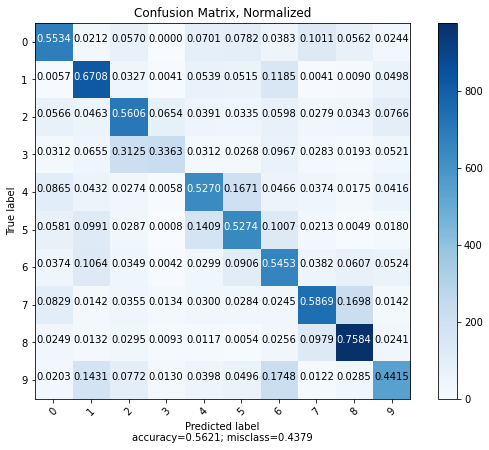

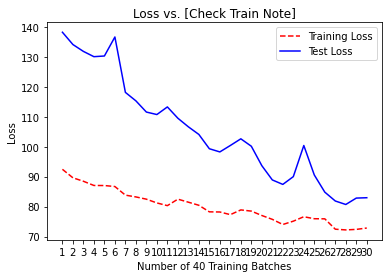

In [ ]:
train(mxresnet50, 10, train_loader, test_loader, 4e-3, criterion, weight_decay= 0.01)

##### Model with Cutmix and Maxup Cross Entropy training

For Further Improvements

# Model with starting learning rates after 3rd epoch did worse than model that was changing every batch

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
Device: cuda
Optimizer: SAM (
Parameter Group 0
    N_sma_threshhold: 5
    alpha: 0.5
    betas: (0.95, 0.999)
    eps: 1e-05
    initial_lr: 0.004
    k: 6
    lr: 0.004
    rho: 0.05
    step_counter: 0
    weight_decay: 0.01
)
Note: Train Loss is calculated after 40 batches of the train loader. While the test loss is calculated over the whole test_loader
For example: a sequence might be train for 40 batches then test on everything and then train for the next 40 batches then test on everything ... 


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch: 1/20 | Batch Number: 40 | Learning Rate: 0.00326665 | Train Loss: 78.52 | Train Accuracy 63.67% | Test Loss: 119.46 | Test Accuracy 66.00%
Epoch: 1/20 | Batch Number: 80 | Learning Rate: 0.00160440 | Train Loss: 74.19 | Train Accuracy 69.10% | Test Loss: 117.45 | Test Accuracy 67.75%
Epoch: 1/20 | Batch Number: 120 | Learning Rate: 0.00023226 | Train Loss: 72.78 | Train Accuracy 69.92% | Test Loss: 116.62 | Test Accuracy 68.34%
Epoch: 2/20 | Batch Number: 40 | Learning Rate: 0.00073335 | Train Loss: 72.60 | Train Accuracy 69.96% | Test Loss: 115.44 | Test Accuracy 68.87%
Epoch: 2/20 | Batch Number: 80 | Learning Rate: 0.00239560 | Train Loss: 72.30 | Train Accuracy 71.09% | Test Loss: 116.35 | Test Accuracy 68.52%
Epoch: 2/20 | Batch Number: 120 | Learning Rate: 0.00376774 | Train Loss: 72.15 | Train Accuracy 70.86% | Test Loss: 121.95 | Test Accuracy 64.27%
Epoch: 3/20 | Batch Number: 40 | Learning Rate: 0.00326665 | Train Loss: 73.20 | Train Accuracy 69.63% | Test Loss: 115.34

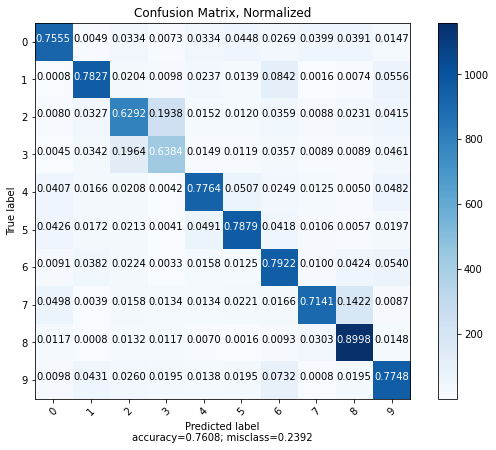

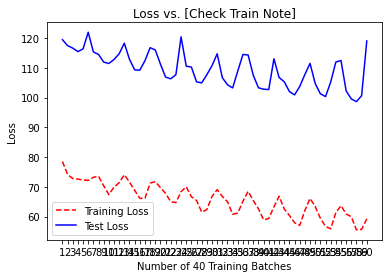

In [ ]:
train(mxresnet50, 20, train_loader, test_loader, 4e-3, criterion, weight_decay= 0.01)

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
Device: cuda
Optimizer: SAM (
Parameter Group 0
    N_sma_threshhold: 5
    alpha: 0.5
    betas: (0.95, 0.999)
    eps: 1e-05
    initial_lr: 0.004
    k: 6
    lr: 0.004
    rho: 0.05
    step_counter: 0
    weight_decay: 0.01
)
Note: Train Loss is calculated after 40 batches of the train loader. While the test loss is calculated over the whole test_loader
For example: a sequence might be train for 40 batches then test on everything and then train for the next 40 batches then test on everything ... 


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch: 1/10 | Batch Number: 40 | Learning Rate: 0.00326665 | Train Loss: 262.45 | Train Accuracy 6.84% | Test Loss: 400.67 | Test Accuracy 13.18%
Epoch: 1/10 | Batch Number: 80 | Learning Rate: 0.00160440 | Train Loss: 214.41 | Train Accuracy 19.45% | Test Loss: 356.75 | Test Accuracy 20.06%
Epoch: 1/10 | Batch Number: 120 | Learning Rate: 0.00023226 | Train Loss: 173.69 | Train Accuracy 21.68% | Test Loss: 318.44 | Test Accuracy 20.87%
Epoch: 2/10 | Batch Number: 40 | Learning Rate: 0.00073335 | Train Loss: 157.94 | Train Accuracy 23.71% | Test Loss: 303.39 | Test Accuracy 21.33%
Epoch: 2/10 | Batch Number: 80 | Learning Rate: 0.00239560 | Train Loss: 130.81 | Train Accuracy 25.08% | Test Loss: 225.17 | Test Accuracy 23.01%
Epoch: 2/10 | Batch Number: 120 | Learning Rate: 0.00376774 | Train Loss: 115.06 | Train Accuracy 26.09% | Test Loss: 178.54 | Test Accuracy 27.64%
Epoch: 3/10 | Batch Number: 40 | Learning Rate: 0.00326665 | Train Loss: 108.22 | Train Accuracy 31.91% | Test Loss: 

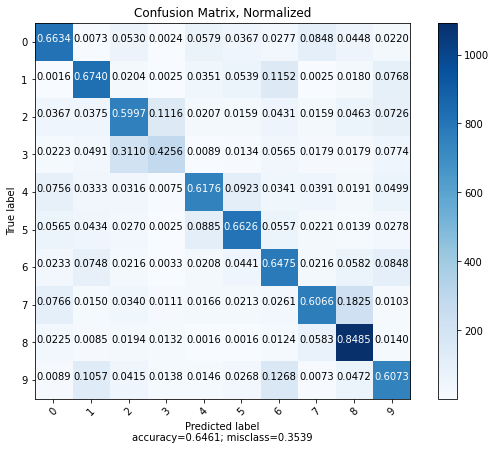

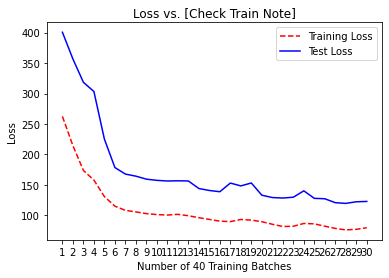

In [ ]:
train(mxresnet50, 10, train_loader, test_loader, 4e-3, criterion, weight_decay= 0.01)

In [ ]:
train(mxresnet50, 10, train_loader, test_loader, 4e-3, criterion, weight_decay= 0.01)

### This model learning rate changes every batch scheduler.step every batch of trainloader

In [ ]:
train(mxresnet50, 5, train_loader, test_loader, 4e-3, criterion, weight_decay = 0.1)

In [ ]:
train(mxresnet50, 5, train_loader, test_loader, 4e-3, criterion, weight_decay = 0.1)

#### This models with change in learning rate every epoch scheduler.step at end of epoch.

In [ ]:
train(mxresnet50, 5, train_loader, test_loader, 4e-3, criterion)

In [ ]:
mxresnet152 = MXResNet(4, [3, 8, 36, 3])
mxresnet152[10].out_features = 10

In [ ]:
train(mxresnet152, 5, train_loader, test_loader, 4e-3, criterion, range_optim = True)

In [ ]:
##https://discuss.pytorch.org/t/how-to-replace-all-relu-activations-in-a-pretrained-network/31591/11
def convert_batchnorm_to_new(model, new):
    for child_name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            setattr(model, child_name, new)
        else:
            convert_batchnorm_to_new(child, new)